In [1]:
!pip install torchdiffeq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [84]:
import torch
import torch.nn as nn
from torchdiffeq import odeint
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

In [129]:
#Data stuff happens here
time_res = 2000
batch_size = 400 #19 batches
t_fine = np.linspace(0,76,time_res)

url = 'http://people.whitman.edu/~hundledr/courses/M250F03/LynxHare.txt'
df = pd.read_csv(url, delim_whitespace=True, header=None, index_col=0)
df.index.name = 'Year'
df.columns = ['Hare', 'Lynx']

raw_years = df.index.to_numpy()  # [1845, ..., 1921]
shifted_years = raw_years - raw_years[0]  # [0, ..., 76]

hares = df['Hare']
lynxes = df['Lynx']

hares_interp = interp1d(shifted_years, hares, kind='cubic')
lynxes_interp = interp1d(shifted_years, lynxes, kind='cubic')

hares_fine = hares_interp(t_fine)
lynxes_fine = lynxes_interp(t_fine)


data = np.array([hares_fine, lynxes_fine]).T
data_orig = data.copy()
# mu,sigma = data.mean(axis=0,keepdims=True),data.std(axis=0,keepdims=True)
# mu,sigma = torch.tensor(mu,dtype=torch.float32),torch.tensor(sigma,dtype=torch.float32)
# data_norm = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
# data = data_norm
data_test = data[:batch_size]
data = data[batch_size:]

t_fine_orig = t_fine.copy()

# t_fine = np.linspace(0,1.0,time_res)
t_fine_test = t_fine[:batch_size]
t_fine = t_fine[batch_size:]

print(data.shape)
print(t_fine.shape)
print(len(data))

(1600, 2)
(1600,)
1600


/tmp/ipython-input-129-2756450696.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(url, delim_whitespace=True, header=None, index_col=0)


In [112]:
# Batching

# num_batches = len(data) // batch_size
# batched_data = data.reshape(num_batches, batch_size, 2)
# batched_data_test = data_test.reshape(-1, batch_size, 2)

# t_batches = t_fine.reshape(num_batches, batch_size)
# t_batches_test = t_fine_test.reshape(-1, batch_size)

In [130]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

What is happening here is that optimal partial dynamics are being learnt (by learning alpha and gamma) while the more complex interaction dynamics are being modelled by seperate neural networks. Another possible approach could be to directly predict x,y and then use the differential equations as a loss mechanism. The problem with that would be yet again finding optimal parameters for said differential model

In [145]:
# ...existing code...

class FuncNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net_func1 = nn.Sequential(
            nn.Linear(2, 32),
            nn.SiLU(),
            nn.Linear(32, 32),
            nn.SiLU(),
            nn.Linear(32, 1)
        )
        self.net_func2 = nn.Sequential(
            nn.Linear(2 , 32),
            nn.SiLU(),
            nn.Linear(32, 32),
            nn.SiLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        f1 = self.net_func1(x)
        f2 = self.net_func2(x)
        return f1, f2

class LVParamLearner(nn.Module):
    def __init__(self):
        super().__init__()
        self.net_a = nn.Sequential(
            nn.Linear(2*time_res, 10),
            nn.SiLU(),
            nn.Linear(10,10),
            nn.SiLU(),
            nn.Linear(10, 1)
        )

        self.net_g = nn.Sequential(
            nn.Linear(2*time_res, 10),
            nn.SiLU(),
            nn.Linear(10,10),
            nn.SiLU(),
            nn.Linear(10, 1)
        )
        self.net_k = nn.Sequential(
            nn.Linear(2*time_res, 10),
            nn.SiLU(),
            nn.Linear(10,10),
            nn.SiLU(),
            nn.Linear(10, 1)
        )
        self.scale = nn.Parameter(torch.tensor(1.0))
        self.sigm = lambda z: nn.functional.softplus(z)

    def forward(self, x):
        x = torch.flatten(torch.tensor(x, dtype=torch.float32))
        a = self.net_a(x)

        g = self.net_g(x)
        k = self.net_k(x)
        return self.sigm(a), self.sigm(g), self.sigm(k)

# ...existing code...

In [146]:
paramlearner = LVParamLearner()
paramlearner.to(device)
FuncNet = FuncNet()
FuncNet.to(device)
optimizer = torch.optim.Adam(paramlearner.parameters(), lr=2e-6)
optimizer_func = torch.optim.Adam(FuncNet.parameters(), lr=2e-6)

In [141]:
lamb = 0.45

def spectrum_loss(y_true, y_pred):
    """
    Compute MSE in frequency space (real-valued FFT comparison).
    y_true and y_pred shape: [T] or [B, T]
    """
    # Subtract mean to remove DC component
    y_true = y_true - y_true.mean(dim=-1, keepdim=True)
    y_pred = y_pred - y_pred.mean(dim=-1, keepdim=True)

    # Compute FFT magnitudes (real-valued)
    f_true = torch.fft.rfft(y_true, dim=-1)
    f_pred = torch.fft.rfft(y_pred, dim=-1)

    # Compute magnitude spectrum
    mag_true = torch.abs(f_true)
    mag_pred = torch.abs(f_pred)

    return torch.mean((mag_true - mag_pred) ** 2)

In [147]:
def make_logistic_lv_dynamics(alpha, gamma, K):
    def dynamics(t, y):
        f1,f2 = FuncNet(y)
        f1 = f1.squeeze(-1)
        f2 = f2.squeeze(-1)
        x, y_pred = y[0], y[1]
        # print(f1,f2)
        dxdt = alpha * x * (1 - x / K) + f1
        dydt = f2 - gamma * y_pred

        return torch.stack([dxdt, dydt])
    return dynamics



This was also attempted using the previous batching based learning, which gave similar results


In [148]:

t_fine_orig = torch.tensor(t_fine_orig,device=device,dtype=torch.float32)
data_orig = torch.tensor(data_orig,device=device,dtype=torch.float32)
pred = 0
for epoch in range(100):
    optimizer.zero_grad()
    optimizer_func.zero_grad()
    y0 = data_orig[0]
    y0 = torch.tensor(y0)
    params = paramlearner(data_orig)

    alp,gam,k = params
    alp,gam,k = alp.squeeze(),gam.squeeze(),k.squeeze()

    dynamics = make_logistic_lv_dynamics(alp,gam,k)

    pred = odeint(dynamics,y0,t_fine_orig,method='dopri5')

    target = torch.tensor(data_orig,device=device)
    loss = torch.mean(((pred - target)**2)) #* (1 - lamb) +  lamb * spectrum_loss(pred,target)


    if torch.isnan(loss):
      print("Loss became NaN — printing parameters")
      print(alp,gam,k)
      break
    loss.backward()
    optimizer.step()

    print(f"EPoch: {epoch} and Loss:{loss}")



/tmp/ipython-input-148-2033967234.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_fine_orig = torch.tensor(t_fine_orig,device=device,dtype=torch.float32)
/tmp/ipython-input-148-2033967234.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_orig = torch.tensor(data_orig,device=device,dtype=torch.float32)
/tmp/ipython-input-148-2033967234.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y0 = torch.tensor(y0)
/tmp/ipython-input-145-2814813062.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTe

EPoch: 0 and Loss:2503.09326171875
EPoch: 1 and Loss:2341.88916015625
EPoch: 2 and Loss:2210.883544921875
EPoch: 3 and Loss:2107.045654296875
EPoch: 4 and Loss:2027.100341796875
EPoch: 5 and Loss:1967.987548828125
EPoch: 6 and Loss:1926.6734619140625
EPoch: 7 and Loss:1899.9910888671875
EPoch: 8 and Loss:1884.7545166015625
EPoch: 9 and Loss:1877.9840087890625
EPoch: 10 and Loss:1877.085205078125
EPoch: 11 and Loss:1879.9346923828125
EPoch: 12 and Loss:1884.88427734375
EPoch: 13 and Loss:1890.706787109375
EPoch: 14 and Loss:1896.515380859375
EPoch: 15 and Loss:1901.70703125
EPoch: 16 and Loss:1905.8822021484375
EPoch: 17 and Loss:1908.8162841796875
EPoch: 18 and Loss:1910.404296875
EPoch: 19 and Loss:1910.63525390625
EPoch: 20 and Loss:1909.57080078125
EPoch: 21 and Loss:1907.31884765625
EPoch: 22 and Loss:1904.03125
EPoch: 23 and Loss:1899.885986328125
EPoch: 24 and Loss:1895.078125
EPoch: 25 and Loss:1889.8148193359375
EPoch: 26 and Loss:1884.30908203125
EPoch: 27 and Loss:1878.760620

In [150]:
alpha,gamma,k = paramlearner(data_orig)
print(alpha,gamma,k)

alpha,gamma,k = alpha.squeeze(),gamma.squeeze(),k.squeeze()
y0 = torch.tensor(data_orig[0],dtype=torch.float32)
print(y0)
pred = odeint(make_logistic_lv_dynamics(alpha,gamma,k),y0,t_fine_orig)
# pred = pred * sigma + mu


/tmp/ipython-input-145-2814813062.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.flatten(torch.tensor(x, dtype=torch.float32))
/tmp/ipython-input-150-340643585.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y0 = torch.tensor(data_orig[0],dtype=torch.float32)


tensor([1.2800], grad_fn=<SoftplusBackward0>) tensor([0.0501], grad_fn=<SoftplusBackward0>) tensor([5.0861], grad_fn=<SoftplusBackward0>)
tensor([19.5800, 30.0900])


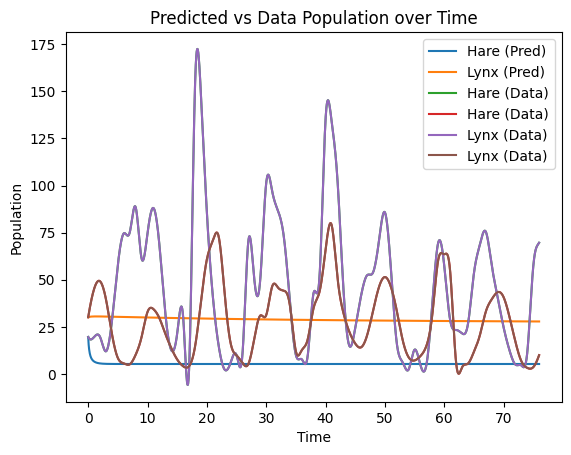

In [152]:
# prompt: Simply plot pred against data

import matplotlib.pyplot as plt
plt.plot(t_fine_orig.cpu().detach().numpy(), pred.cpu().detach().numpy()[:, 0], label='Hare (Pred)')
plt.plot(t_fine_orig.cpu().detach().numpy(), pred.cpu().detach().numpy()[:, 1], label='Lynx (Pred)')
plt.plot(t_fine_orig, data_orig, label='Hare (Data)')
plt.plot(t_fine_orig, data_orig, label='Lynx (Data)')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Predicted vs Data Population over Time')
plt.legend()
plt.show()